In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['agg.path.chunksize'] = 9000000
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve
from yellowbrick.target import ClassBalance
import seaborn as sns
import itertools
import xgboost as xgb
from xgboost import XGBClassifier
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
%matplotlib inline

In [177]:
check_df = pd.read_csv('data/KB1H1DSPRFMYMCUFXT09_header.txt', sep='|')

In [7]:
# Loading data from Wells Fargo
wells_df = pd.read_csv('data/KB1H1DSPRFMYMCUFXT09_header.txt', sep='|')


# Dataset cleanup
* Drop/rename columns where appropriate
* Drop rows as appropriate
* one-hot encode categorical variables

In [5]:
wells_df['Co-Applicant or Co-Borrower - Name and Version of Credit Scoring Model'].value_counts()

9     700783
10    244409
1      44761
3      19690
2      17112
Name: Co-Applicant or Co-Borrower - Name and Version of Credit Scoring Model, dtype: int64

In [4]:
wells_df.describe()

,Record Identifier,Loan Type,Loan Purpose,Preapproval,Construction Method,Occupancy Type,Loan Amount,Action Taken,County,Census Tract,Ethnicity of Applicant or Borrower: 1,Ethnicity of Applicant or Borrower: 2,Ethnicity of Applicant or Borrower: 3,Ethnicity of Applicant or Borrower: 4,Ethnicity of Applicant or Borrower: 5,Ethnicity of Co-Applicant or Co-Borrower: 1,Ethnicity of Co-Applicant or Co-Borrower: 2,Ethnicity of Co-Applicant or Co-Borrower: 3,Ethnicity of Co-Applicant or Co-Borrower: 4,Ethnicity of Co-Applicant or Co-Borrower: 5,Ethnicity of Applicant or Borrower Collected on the Basis of Visual Observation or Surname,Ethnicity of Co-Applicant or Co-Borrower Collected on the Basis of Visual Observation or Surname,Race of Applicant or Borrower: 1,Race of Applicant or Borrower: 2,Race of Applicant or Borrower: 3,Race of Applicant or Borrower: 4,Race of Applicant or Borrower: 5,Race of Co-Applicant or Co-Borrower: 1,Race of Co-Applicant or Co-Borrower: 2,Race of Co-Applicant or Co-Borrower: 3,Race of Co-Applicant or Co-Borrower: 4,Race of Co-Applicant or Co-Borrower: 5,Race of Applicant or Borrower Collected on the Basis of Visual Observation or Surname,Race of Co-Applicant or Co-Borrower Collected on the Basis of Visual Observation or Surname,Sex of Applicant or Borrower,Sex of Co-Applicant or Co-Borrower,Sex of Applicant or Borrower Collected on the Basis of Visual Observation or Surname,Sex of Co-Applicant or Co-Borrower Collected on the Basis of Visual Observation or Surname,Income,Type of Purchaser,Rate Spread,HOEPA Status,Lien Status,Applicant or Borrower - Name and Version of Credit Scoring Model,Co-Applicant or Co-Borrower - Name and Version of Credit Scoring Model,Reason for Denial: 1,Reason for Denial: 2,Reason for Denial: 3,Reason for Denial: 4,Total Loan Costs,Total Points and Fees,Origination Charges,Discount Points,Lender Credits,Interest Rate,Prepayment Penalty Term,Combined Loan-to-Value Ratio,Loan Term,Introductory Rate Period,Balloon Payment,Interest-Only Payments,Negative Amortization,Other Non-Amortizing Features,Property Value,Manufactured Home Secured Property Type,Manufactured Home Land Property Interest,Multifamily Affordable Units,Submission of Application,Initially Payable to Your Institution,Automated Underwriting System: 1,Automated Underwriting System: 2,Automated Underwriting System: 3,Automated Underwriting System: 4,Automated Underwriting System: 5,Reverse Mortgage,Open-End Line of Credit,Business or Commercial Purpose
count,1026755.0,1.026755e+06,1.026755e+06,1026755.0,1.026755e+06,1.026755e+06,1.026755e+06,1.026755e+06,1.026678e+06,1.026678e+06,1.022420e+06,43666.000000,756.000000,32.000000,10.000000,1.025294e+06,17441.000000,319.000000,4.000000,3.000000,1.026755e+06,1.026755e+06,1.024266e+06,52411.000000,3341.000000,367.000000,130.000000,1.025983e+06,24116.000000,1384.000000,138.000000,42.000000,1.026755e+06,1.026755e+06,1.026755e+06,1.026755e+06,1.026755e+06,1.026755e+06,925841.000000,1.026755e+06,287229.000000,1.026755e+06,1.026755e+06,1.026755e+06,1.026755e+06,1.026755e+06,72878.000000,19023.000000,2411.000000,587123.000000,0.0,588374.000000,166196.000000,265192.000000,708010.000000,31740.0,456724.000000,1.020518e+06,61036.000000,1.026755e+06,1.026755e+06,1.026755e+06,1.026755e+06,8.798830e+05,1.026755e+06,1.026755e+06,1505.000000,1.026755e+06,1.026755e+06,1.026755e+06,144021.000000,123537.0,0.0,0.0,1.026755e+06,1.026755e+06,1.026755e+06
mean,2.0,1.141138e+00,1.174022e+01,2.0,1.008377e+00,1.139754e+00,3.165218e+05,3.800118e+00,2.619660e+04,2.619681e+10,2.271685e+00,11.711354,13.010582,13.343750,13.800000,3.703004e+00,11.587868,12.877743,13.000000,13.666667,2.043026e+00,3.062117e+00,5.292666e+00,20.465437,22.673451,24.607629,24.446154,6.751281e+00,21.025419,23.387283,26.188406,28.357143,2.041977e+00,3.061838e+00,1.571603e+00,3.547926e+00,2.042056e+00,3.061660e+00,154.048498,7.592503e-01,0.428227,2.407511e+00,1.146633e+00,6.252027e+00,8.657559e+00,8.940914e+00,3.761108,3.675656,3.83865

In [5]:
wells_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1026755 entries, 0 to 1026754
Data columns (total 85 columns):
 #   Column                                                                                            Non-Null Count    Dtype  
---  ------                                                                                            --------------    -----  
 0   Record Identifier                                                                                 1026755 non-null  int64  
 1   Legal Entity Identifier (LEI)                                                                     1026755 non-null  object 
 2   Loan Type                                                                                         1026755 non-null  int64  
 3   Loan Purpose                                                                                      1026755 non-null  int64  
 4   Preapproval                                                                                       1026755 no

In [179]:
# Change LEI to Wells Fargo
wells_df['Legal Entity Identifier (LEI)'] = 'Wells Fargo'


# Selecting target variable
Action Taken: 
1: Loan originated
2: Application approved but not accepted
3: Application denied
4: Application withdrawn by applicant
5: File closed for incompleteness
6: Purchased loan
7: Preapproval request denied
8: Preapproval request approved but not accepted

Interpreting which actions are 'approved:' 
1, 2, 6

Denied:
3

Irrelevant to model: 4, 5, 7, 8

In [8]:
# 'Action Taken' will be target - remove '4,5': Application withdrawn by applicant
wells_df = wells_df[~wells_df['Action Taken'].isin([4,5,7,8])]

In [9]:
# Simplify 'Action Taken' to approved or denied 
wells_df['Action Taken'] = wells_df['Action Taken'].map(lambda x: 0 if x ==3 else 1)

## Dropping Additional Columns
* Dropped columns with std of 0, indicating all rows == same value 
* Dropped columns where num of NA rows >= 150
* Excluded business loans
* Excluded reverse mortgage, multifamily units, non-primary residence
* Dropped Record Identifier - redundat with LEI

In [ ]:
wells_df

In [10]:
# wells_df = wells_df.drop('Preapproval', axis=1)
# wells_df = wells_df.drop('Prepayment Penalty Term', axis=1)
# wells_df = wells_df.drop('Automated Underwriting System: 3', axis=1)
# wells_df = wells_df.drop('Automated Underwriting System: 4', axis=1)
# wells_df = wells_df.drop('Automated Underwriting System: 5', axis=1)
# wells_df = wells_df.drop('Total Points and Fees', axis=1)
# wells_df = wells_df.drop('Ethnicity of Applicant or Borrower: 4', axis=1)
# wells_df = wells_df.drop('Ethnicity of Applicant or Borrower: 5', axis=1)
# wells_df = wells_df.drop('Ethnicity of Co-Applicant or Co-Borrower: 4', axis=1)
# wells_df = wells_df.drop('Ethnicity of Co-Applicant or Co-Borrower: 5', axis=1)
# wells_df = wells_df.drop('Race of Applicant or Borrower: 5', axis=1)
# wells_df = wells_df.drop('Race of Co-Applicant or Co-Borrower: 4', axis=1)
# wells_df = wells_df.drop('Race of Co-Applicant or Co-Borrower: 5', axis=1)
# wells_df = wells_df[wells_df['Business or Commercial Purpose'] == 2]
# wells_df = wells_df.drop('Reverse Mortgage', axis=1)
# wells_df = wells_df.drop('Multifamily Affordable Units', axis=1)
# wells_df = wells_df[wells_df['Occupancy Type'] == 1]
# wells_df = wells_df.drop('Record Identifier', axis=1)
# wells_df = wells_df.drop('Age of Applicant >= 62', axis=1)
# wells_df = wells_df.drop('Age of Co-Applicant >= 62', axis=1)
# wells_df = wells_df.drop('Legal Entity Identifier (LEI)', axis=1)
# wells_df = wells_df.drop('Occupancy Type', axis=1)
# wells_df = wells_df.drop('Business or Commercial Purpose', axis=1)

In [10]:
wells_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889191 entries, 0 to 1026753
Data columns (total 85 columns):
 #   Column                                                                                            Non-Null Count   Dtype  
---  ------                                                                                            --------------   -----  
 0   Record Identifier                                                                                 889191 non-null  int64  
 1   Legal Entity Identifier (LEI)                                                                     889191 non-null  object 
 2   Loan Type                                                                                         889191 non-null  int64  
 3   Loan Purpose                                                                                      889191 non-null  int64  
 4   Preapproval                                                                                       889191 non-null  

## Handling categorical variables
* ```States``` column contains 17 nan that were dropped
* Convert ```States``` to numerical
* ```Visual Observation of Race/Ethnicity``` columns:
    * Combined codes 2,3 (```Race```) and and treated this as a yes/no question (i.e. was race noted by observation rather than self-report?)
    * Shortened these column names
* ```Age``` columns - mapped using ordinal ranking
* ```Debt-to-Income``` 
    * This column had both string and integer values. The string values were intervals that include values less than 36% and greater than 50%. Values between 36-50% were expressed as integers. My assumption is that each point will affect mortgage lending (whether approval, rate, etc) significantly enough that the integers were intentionally not binned. So, rather than creating additional bins, I changed the bins to the median value, or the close value above or below in increments of 5. 


In [11]:
# create dataframe containing all unique entries of wells_df
states = wells_df['State'].unique().astype(str)

In [12]:
wells_df['State'].isnull().sum().sum()

17

In [13]:
wells_df = wells_df[~wells_df['State'].isnull()]

In [14]:
states = np.sort(wells_df['State'].unique().astype(str))
states

array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN',
       'TX', 'UT', 'VA', 'VI', 'VT', 'WA', 'WI', 'WV', 'WY'], dtype='<U2')

In [15]:
# Cast to list to map str to int
states = list(states)

In [16]:
# Create a mapper dictionary and apply numerical encoding to 'State' column
state_mapper = {}
for idx, state in enumerate(states): 
    state_mapper[state] = idx

In [17]:
wells_df['State'] = wells_df['State'].map(state_mapper)

In [190]:
# checking if rows where the Race of the applicant differs from the visual race column
# It appears the visual observation is only used if not reported by applicant. Will use encoding. 
diff_race = wells_df[wells_df['Race of Applicant or Borrower: 1'] != wells_df['Race of Applicant or Borrower Collected on the Basis of Visual Observation or Surname']
    ]

In [191]:
diff_race[diff_race['Race of Applicant or Borrower: 1'] != 7.0]

KeyboardInterrupt: 

In [ ]:
wells_df['Race of Applicant or Borrower Collected on the Basis of Visual Observation or Surname'].value_counts()

In [18]:
wells_df = wells_df.rename(columns = {'Race of Applicant or Borrower Collected on the Basis of Visual Observation or Surname': 'Race Visual Obs'})

In [193]:
wells_df['Race Visual Obs'].value_counts()

2    724994
3     65385
1     21596
Name: Race Visual Obs, dtype: int64

In [19]:
# 1: observation made, 0: observation not made
wells_df['Race Visual Obs'] = wells_df['Race Visual Obs'].map(lambda x: 1 if x == 1 else 0)

In [195]:
wells_df['Race Visual Obs'].value_counts()

0    790379
1     21596
Name: Race Visual Obs, dtype: int64

In [20]:
# Debt-to-Income Ratio: some values are expressed as a range, other are expressed exactly. 

DIR_mapper = {'20%-<30%': 25, '30%-<36%': 33, '>60%': 65, '<20%': 15, '50%-60%': 55}


wells_df['Debt-to-Income Ratio'] = wells_df['Debt-to-Income Ratio'].map(lambda x: DIR_mapper[x] if x in DIR_mapper else int(x), na_action='ignore')

In [21]:
wells_df['Debt-to-Income Ratio'].value_counts()

25.0    81607
33.0    71580
65.0    44367
15.0    29305
55.0    25655
44.0    15682
42.0    14146
39.0    13812
41.0    13491
43.0    13453
38.0    13263
40.0    13162
37.0    13003
36.0    12633
49.0     7260
45.0     6894
48.0     6738
46.0     6719
47.0     6455
Name: Debt-to-Income Ratio, dtype: int64

# General EDA
* Dataset now down to 811975 rows 
* ```Census Tract``` refers to a geographic region
* ```Age of Applicant``` contains ~65,000 nan values. Used KNN Imputation

In [64]:
wells_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 811975 entries, 0 to 1026621
Data columns (total 69 columns):
 #   Column                                                                                            Non-Null Count   Dtype  
---  ------                                                                                            --------------   -----  
 0   Legal Entity Identifier (LEI)                                                                     811975 non-null  object 
 1   Loan Type                                                                                         811975 non-null  int64  
 2   Loan Purpose                                                                                      811975 non-null  int64  
 3   Construction Method                                                                               811975 non-null  int64  
 4   Occupancy Type                                                                                    811975 non-null  

In [26]:
# There are two '8888' entries possible (str or int). Combined into one column called 'null'
 
age = pd.DataFrame(wells_df['Age of Applicant or Borrower'].value_counts()).T
age['null'] = age[8888] + age['8888']
age = age.drop(columns=[8888, '8888'], axis=1)
age = age.T.reset_index()
age

,index,Age of Applicant or Borrower
0,35-44,213214
1,45-54,187796
2,25-34,163052
3,55-64,141880
4,65-74,74310
5,>74,23816
6,<25,16966
7,9999,1
8,null,68137


In [27]:
64673/age['Age of Applicant or Borrower'].sum()*100

7.273395923398398

<BarContainer object of 9 artists>

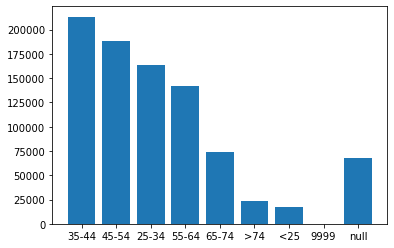

In [28]:
# Plotting to visualize num nan: ~7% of entries
fig, ax = plt.subplots()
ax.bar(age['index'], age['Age of Applicant or Borrower'])

In [66]:
wells_df[wells_df['Age of Applicant or Borrower'] == 8888]

,Legal Entity Identifier (LEI),Loan Type,Loan Purpose,Construction Method,Occupancy Type,Loan Amount,Action Taken,State,County,Census Tract,Ethnicity of Applicant or Borrower: 1,Ethnicity of Applicant or Borrower: 2,Ethnicity of Applicant or Borrower: 3,Ethnicity of Co-Applicant or Co-Borrower: 1,Ethnicity of Co-Applicant or Co-Borrower: 2,Ethnicity of Co-Applicant or Co-Borrower: 3,Ethnicity of Applicant or Borrower Collected on the Basis of Visual Observation or Surname,Ethnicity of Co-Applicant or Co-Borrower Collected on the Basis of Visual Observation or Surname,Race of Applicant or Borrower: 1,Race of Applicant or Borrower: 2,Race of Applicant or Borrower: 3,Race of Applicant or Borrower: 4,Race of Co-Applicant or Co-Borrower: 1,Race of Co-Applicant or Co-Borrower: 2,Race of Co-Applicant or Co-Borrower: 3,Race Visual Obs,Race of Co-Applicant or Co-Borrower Collected on the Basis of Visual Observation or Surname,Sex of Applicant or Borrower,Sex of Co-Applicant or Co-Borrower,Sex of Applicant or Borrower Collected on the Basis of Visual Observation or Surname,Sex of Co-Applicant or Co-Borrower Collected on the Basis of Visual Observation or Surname,Age of Applicant or Borrower,Age of Applicant >= 62,Age of Co-Applicant or Co-Borrower,Age of Co-Applicant >= 62,Income,Type of Purchaser,Rate Spread,HOEPA Status,Lien Status,Applicant or Borrower - Name and Version of Credit Scoring Model,Co-Applicant or Co-Borrower - Name and Version of Credit Scoring Model,Reason for Denial: 1,Reason for Denial: 2,Reason for Denial: 3,Reason for Denial: 4,Total Loan Costs,Origination Charges,Discount Points,Lender Credits,Interest Rate,Debt-to-Income Ratio,Combined Loan-to-Value Ratio,Loan Term,Introductory Rate Period,Balloon Payment,Interest-Only Payments,Negative Amortization,Other Non-Amortizing Features,Property Value,Manufactured Home Secured Property Type,Manufactured Home Land Property Interest,Total Units,Submission of Application,Initially Payable to Your Institution,Automated Underwriting System: 1,Automated Underwriting System: 2,Open-End Line of Credit,Business or Commercial Purpose
0,Wells Fargo,2,5,1,1,85000,1,GA,13067.0,1.306703e+10,4.0,NaN,NaN,4.0,NaN,NaN,3,3,7.0,NaN,NaN,NaN,7.0,NaN,NaN,0,3,4,4,3,3,8888,NaN,8888,NaN,NaN,0,NaN,3,1,9,9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.500,NaN,NaN,360.0,NaN,2,2,2,2,105000.0,3,5,1,3,3,6,NaN,2,2
1,Wells Fargo,1,5,1,1,5000,1,NJ,34003.0,3.400304e+10,4.0,NaN,NaN,4.0,NaN,NaN,3,3,7.0,NaN,NaN,NaN,7.0,NaN,NaN,0,3,4,4,3,3,8888,NaN,8888,NaN,NaN,0,NaN,3,1,9,9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.375,NaN,NaN,360.0,NaN,2,2,2,2,175000.0,3,5,1,3,3,6,NaN,2,2
2,Wells Fargo,1,5,1,1,65000,1,SC,45007.0,4.500701e+10,4.0,NaN,NaN,4.0,NaN,NaN,3,3,7.0,NaN,NaN,NaN,7.0,NaN,NaN,0,3,4,4,3,3,8888,NaN,8888,NaN,NaN,0,NaN,3,1,9,9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.250,NaN,NaN,480.0,NaN,2,2,2,2,95000.0,3,5,1,3,3,6,NaN,2,2
3,Wells Fargo,2,5,1,1,115000,1,FL,12081.0,1.208100e+10,4.0,NaN,NaN,4.0,NaN,NaN,3,3,7.0,NaN,NaN,NaN,7.0,NaN,NaN,0,3,4,4,3,3,8888,NaN,8888,NaN,NaN,0,NaN,2,1,9,9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.500,NaN,NaN,360.0,NaN,2,2,2,2,155000.0,3,5,1,3,3,6,NaN,2,2
4,Wells Fargo,2,5,1,1,205000,1,SC,45091.0,4.509106e+10,4.0,NaN,NaN,4.0,NaN,NaN,3,3,7.0,NaN,NaN,NaN,7.0,NaN,NaN,0,3,4,4,3,3,8888,NaN,8888,NaN,NaN,2,NaN,3,1,9,9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.000,NaN,NaN,360.0,NaN,2,2,2,2,215000.0,3,5,1,3,3,6,NaN,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57339,Wells Fargo,2,5,1,1,145000,1,RI,44003.0,4.400302e+10,4.0,NaN,NaN,4.0,NaN,NaN,3,3,7.0,NaN,NaN,NaN,7.0,NaN,NaN,0,3,4,4,3,3,8888,NaN,8888,NaN,NaN,0,NaN,2,1,9,9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.500,NaN,NaN,360.0,NaN,2,2,2,2,195000.0,3,5,1,3,3,6,NaN,2,2
57340,Wells Fargo,2,5,1,1,65000,1,PA,42107.0,4.210700e+10,4.0,NaN,NaN,4.0,NaN,NaN,3,3,7.0,NaN,NaN

In [22]:
# Convert int(8888) and str(8888) to nan
wells_df['Age of Applicant or Borrower'] = wells_df['Age of Applicant or Borrower'] \
                                                    .apply(lambda x: np.nan if (x == 8888 or x == '8888') else x)

In [203]:
wells_df['Age of Applicant or Borrower'].isnull().sum()

64673

In [23]:
age_dict = {'<25': 0, '25-34': 1, '35-44': 2, '45-54': 3, '55-64': 4, '65-74': 5, '>74': 6}

In [24]:
# Couldn't get OrdinalEncoder to work with nan so used map. Kept nan for imputation later
wells_df['Age of Applicant or Borrower'] = wells_df['Age of Applicant or Borrower'].map(age_dict, na_action='ignore')

In [25]:
wells_df['Age of Co-Applicant or Co-Borrower'] = wells_df['Age of Co-Applicant or Co-Borrower'].map(age_dict, na_action='ignore')

In [26]:
wells_df['Age of Applicant or Borrower'].isna().sum()

64673

In [208]:
wells_df['Age of Applicant or Borrower'].value_counts()

2.0    197702
3.0    167397
1.0    157130
4.0    122435
5.0     64874
6.0     21124
0.0     16640
Name: Age of Applicant or Borrower, dtype: int64

In [209]:
wells_df['Ethnicity of Applicant or Borrower: 3'].notnull().sum()

590

In [228]:
# Impute Age of Applicant using KNN
imputer = KNNImputer(missing_values=np.nan)
wells_df['Age of Applicant or Borrower'] = imputer.fit_transform(wells_df['Age of Applicant or Borrower'] \
                                                                 .values.reshape(-1,1))


In [230]:
# pickle the dataframe because KNN took a long time to run
wells_df.to_pickle('wells_df.pkl')

In [231]:
wells_df['Age of Applicant or Borrower'].isnull().sum()

0

In [36]:
wells_df['Race of Applicant or Borrower: 1'].value_counts().sum()

810174

In [46]:
wells_base = wells_df.fillna(0)

In [47]:
# feature (X) and target(y) matrices
X = wells_base.drop(['Action Taken', 'Reason for Denial: 1', 
                     'Reason for Denial: 2', 'Reason for Denial: 3','Reason for Denial: 4'], axis=1)
y = wells_base['Action Taken']

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, stratify=y, random_state=42)

In [ ]:
X_train['Race of Applicant or Borrower: 1']

TypeError: missing a required argument: 'y'

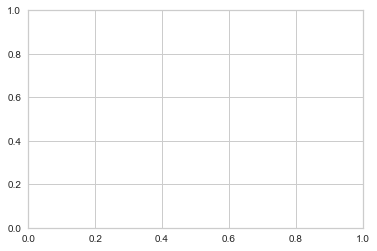

In [52]:
fig, ax = plt.subplots()
ax.scatter(X_train['Race of Applicant or Borrower: 1'])
plt.show()

# Baseline model
There are many nan values in the ethnicity and race variables, and because I will be evaluating for bias, I don't want to drop these values, even though they are few. First, I will create a baseline model and evaluate several algorithms for accuracy before adjusting the way nan values are handled. For the baseline model, I'll fill nan values with zeroes and use a StandardScaler. 

In [232]:
wells_base = wells_df.fillna(0)
wells_base.head()

,Legal Entity Identifier (LEI),Loan Type,Loan Purpose,Construction Method,Occupancy Type,Loan Amount,Action Taken,State,County,Census Tract,Ethnicity of Applicant or Borrower: 1,Ethnicity of Applicant or Borrower: 2,Ethnicity of Applicant or Borrower: 3,Ethnicity of Co-Applicant or Co-Borrower: 1,Ethnicity of Co-Applicant or Co-Borrower: 2,Ethnicity of Co-Applicant or Co-Borrower: 3,Ethnicity of Applicant or Borrower Collected on the Basis of Visual Observation or Surname,Ethnicity of Co-Applicant or Co-Borrower Collected on the Basis of Visual Observation or Surname,Race of Applicant or Borrower: 1,Race of Applicant or Borrower: 2,Race of Applicant or Borrower: 3,Race of Applicant or Borrower: 4,Race of Co-Applicant or Co-Borrower: 1,Race of Co-Applicant or Co-Borrower: 2,Race of Co-Applicant or Co-Borrower: 3,Race Visual Obs,Race of Co-Applicant or Co-Borrower Collected on the Basis of Visual Observation or Surname,Sex of Applicant or Borrower,Sex of Co-Applicant or Co-Borrower,Sex of Applicant or Borrower Collected on the Basis of Visual Observation or Surname,Sex of Co-Applicant or Co-Borrower Collected on the Basis of Visual Observation or Surname,Age of Applicant or Borrower,Age of Co-Applicant or Co-Borrower,Income,Type of Purchaser,Rate Spread,HOEPA Status,Lien Status,Applicant or Borrower - Name and Version of Credit Scoring Model,Co-Applicant or Co-Borrower - Name and Version of Credit Scoring Model,Reason for Denial: 1,Reason for Denial: 2,Reason for Denial: 3,Reason for Denial: 4,Total Loan Costs,Origination Charges,Discount Points,Lender Credits,Interest Rate,Debt-to-Income Ratio,Combined Loan-to-Value Ratio,Loan Term,Introductory Rate Period,Balloon Payment,Interest-Only Payments,Negative Amortization,Other Non-Amortizing Features,Property Value,Manufactured Home Secured Property Type,Manufactured Home Land Property Interest,Total Units,Submission of Application,Initially Payable to Your Institution,Automated Underwriting System: 1,Automated Underwriting System: 2,Open-End Line of Credit,Business or Commercial Purpose
0,Wells Fargo,2,5,1,1,85000,1,10,13067.0,1.306703e+10,4.0,0.0,0.0,4.0,0.0,0.0,3,3,7.0,0.0,0.0,0.0,7.0,0.0,0.0,0,3,4,4,3,3,2.670378,0.0,0.0,0,0.0,3,1,9,9,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.500,0.0,0.0,360.0,0.0,2,2,2,2,105000.0,3,5,1,3,3,6,0.0,2,2
1,Wells Fargo,1,5,1,1,5000,1,31,34003.0,3.400304e+10,4.0,0.0,0.0,4.0,0.0,0.0,3,3,7.0,0.0,0.0,0.0,7.0,0.0,0.0,0,3,4,4,3,3,2.670378,0.0,0.0,0,0.0,3,1,9,9,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.375,0.0,0.0,360.0,0.0,2,2,2,2,175000.0,3,5,1,3,3,6,0.0,2,2
2,Wells Fargo,1,5,1,1,65000,1,41,45007.0,4.500701e+10,4.0,0.0,0.0,4.0,0.0,0.0,3,3,7.0,0.0,0.0,0.0,7.0,0.0,0.0,0,3,4,4,3,3,2.670378,0.0,0.0,0,0.0,3,1,9,9,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.250,0.0,0.0,480.0,0.0,2,2,2,2,95000.0,3,5,1,3,3,6,0.0,2,2
3,Wells Fargo,2,5,1,1,115000,1,9,12081.0,1.208100e+10,4.0,0.0,0.0,4.0,0.0,0.0,3,3,7.0,0.0,0.0,0.0,7.0,0.0,0.0,0,3,4,4,3,3,2.670378,0.0,0.0,0,0.0,2,1,9,9,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.500,0.0,0.0,360.0,0.0,2,2,2,2,155000.0,3,5,1,3,3,6,0.0,2,2
4,Wells Fargo,2,5,1,1,205000,1,41,45091.0,4.509106e+10,4.0,0.0,0.0,4.0,0.0,0.0,3,3,7.0,0.0,0.0,0.0,7.0,0.0,0.0,0,3,4,4,3,3,2.670378,0.0,0.0,2,0.0,3,1,9,9,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.000,0.0,0.0,360.0,0.0,2,2,2,2,215000.0,3,5,1,3,3,6,0.0,2,2


In [233]:
# feature (X) and target(y) matrices
X = wells_base.drop(['Legal Entity Identifier (LEI)', 'Action Taken'], axis=1)
y = wells_base['Action Taken']

In [234]:
## Create holdout sample
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=True)

In [235]:
X.head()

,Loan Type,Loan Purpose,Construction Method,Occupancy Type,Loan Amount,State,County,Census Tract,Ethnicity of Applicant or Borrower: 1,Ethnicity of Applicant or Borrower: 2,Ethnicity of Applicant or Borrower: 3,Ethnicity of Co-Applicant or Co-Borrower: 1,Ethnicity of Co-Applicant or Co-Borrower: 2,Ethnicity of Co-Applicant or Co-Borrower: 3,Ethnicity of Applicant or Borrower Collected on the Basis of Visual Observation or Surname,Ethnicity of Co-Applicant or Co-Borrower Collected on the Basis of Visual Observation or Surname,Race of Applicant or Borrower: 1,Race of Applicant or Borrower: 2,Race of Applicant or Borrower: 3,Race of Applicant or Borrower: 4,Race of Co-Applicant or Co-Borrower: 1,Race of Co-Applicant or Co-Borrower: 2,Race of Co-Applicant or Co-Borrower: 3,Race Visual Obs,Race of Co-Applicant or Co-Borrower Collected on the Basis of Visual Observation or Surname,Sex of Applicant or Borrower,Sex of Co-Applicant or Co-Borrower,Sex of Applicant or Borrower Collected on the Basis of Visual Observation or Surname,Sex of Co-Applicant or Co-Borrower Collected on the Basis of Visual Observation or Surname,Age of Applicant or Borrower,Age of Co-Applicant or Co-Borrower,Income,Type of Purchaser,Rate Spread,HOEPA Status,Lien Status,Applicant or Borrower - Name and Version of Credit Scoring Model,Co-Applicant or Co-Borrower - Name and Version of Credit Scoring Model,Reason for Denial: 1,Reason for Denial: 2,Reason for Denial: 3,Reason for Denial: 4,Total Loan Costs,Origination Charges,Discount Points,Lender Credits,Interest Rate,Debt-to-Income Ratio,Combined Loan-to-Value Ratio,Loan Term,Introductory Rate Period,Balloon Payment,Interest-Only Payments,Negative Amortization,Other Non-Amortizing Features,Property Value,Manufactured Home Secured Property Type,Manufactured Home Land Property Interest,Total Units,Submission of Application,Initially Payable to Your Institution,Automated Underwriting System: 1,Automated Underwriting System: 2,Open-End Line of Credit,Business or Commercial Purpose
0,2,5,1,1,85000,10,13067.0,1.306703e+10,4.0,0.0,0.0,4.0,0.0,0.0,3,3,7.0,0.0,0.0,0.0,7.0,0.0,0.0,0,3,4,4,3,3,2.670378,0.0,0.0,0,0.0,3,1,9,9,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.500,0.0,0.0,360.0,0.0,2,2,2,2,105000.0,3,5,1,3,3,6,0.0,2,2
1,1,5,1,1,5000,31,34003.0,3.400304e+10,4.0,0.0,0.0,4.0,0.0,0.0,3,3,7.0,0.0,0.0,0.0,7.0,0.0,0.0,0,3,4,4,3,3,2.670378,0.0,0.0,0,0.0,3,1,9,9,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.375,0.0,0.0,360.0,0.0,2,2,2,2,175000.0,3,5,1,3,3,6,0.0,2,2
2,1,5,1,1,65000,41,45007.0,4.500701e+10,4.0,0.0,0.0,4.0,0.0,0.0,3,3,7.0,0.0,0.0,0.0,7.0,0.0,0.0,0,3,4,4,3,3,2.670378,0.0,0.0,0,0.0,3,1,9,9,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.250,0.0,0.0,480.0,0.0,2,2,2,2,95000.0,3,5,1,3,3,6,0.0,2,2
3,2,5,1,1,115000,9,12081.0,1.208100e+10,4.0,0.0,0.0,4.0,0.0,0.0,3,3,7.0,0.0,0.0,0.0,7.0,0.0,0.0,0,3,4,4,3,3,2.670378,0.0,0.0,0,0.0,2,1,9,9,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.500,0.0,0.0,360.0,0.0,2,2,2,2,155000.0,3,5,1,3,3,6,0.0,2,2
4,2,5,1,1,205000,41,45091.0,4.509106e+10,4.0,0.0,0.0,4.0,0.0,0.0,3,3,7.0,0.0,0.0,0.0,7.0,0.0,0.0,0,3,4,4,3,3,2.670378,0.0,0.0,2,0.0,3,1,9,9,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.000,0.0,0.0,360.0,0.0,2,2,2,2,215000.0,3,5,1,3,3,6,0.0,2,2


In [236]:
kf=5

In [ ]:
# KNN
knn_pipe = Pipeline([('scaler', StandardScaler()), ('classifier', KNeighborsClassifier())])
knn_grid_params = {}
knn_grid = GridSearchCV(knn_pipe, knn_grid_params, cv=kf, scoring = 'recall')
knn_grid.fit(X_train, y_train)
print("KNN Testing Accuracy: {}".format(knn_grid.score(X_test, y_test)))

In [ ]:
# Logistic Regression
lr_pipe = Pipeline([('scaler', StandardScaler()), ('classifier', LogisticRegression())])
lr_grid_params = {}
lr_grid = GridSearchCV(lr_pipe, lr_grid_params, cv=kf, scoring = 'accuracy')
lr_grid.fit(X_train, y_train)
print("Logistic Regression Testing Accuracy: {}".format(lr_grid.score(X_test, y_test)))

In [ ]:
# Decision Tree
dt_pipe = Pipeline([('scaler', StandardScaler()), ('classifier', DecisionTreeClassifier())])
dt_grid_params = {} # fill in later in lecture
dt_grid = GridSearchCV(dt_pipe, dt_grid_params, cv=kf, scoring = 'accuracy')
dt_grid.fit(X_train, y_train)
print("Decision Tree Testing Accuracy: {}".format(dt_grid.score(X_test, y_test)))

In [ ]:
# Random Forest
rf_pipe = Pipeline([('scaler', StandardScaler()), ('classifier', RandomForestClassifier())])
rf_grid_params = {}
rf_grid = GridSearchCV(rf_pipe, rf_grid_params, cv=kf, scoring = 'accuracy')
rf_grid.fit(X_train, y_train) # fill in later in lecture
print("Random Forest Testing Accuracy: {}".format(rf_grid.score(X_test, y_test)))

In [ ]:
# Stochastic Gradient Descent
sgd_pipe = Pipeline([('scaler', StandardScaler()), ('classifier', SGDClassifier())])
sgd_pipe.fit(X_train, y_train)
print("SGD Classifier: {}".format(rf_grid.score(X_test, y_test)))

In [ ]:
# Gradient Boosted Trees

# https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
# should only use either min_samples_leaf or min_weight_fraction_leaf
# max_depth should be tuned using CV (use this or max_leaf_nodes, if both one ignored)
# max_features = sqrt(N)
grid_params = {'min_samples_split': [50, 70, 90], 'min_samples_leaf': [range(10,100,10)], 
               'max_depth': [1,2,3], 'max_features': [2, 4, 6, 8]}
sgd_pipe = Pipeline([('scaler', StandardScaler()), ('classifier', GradientBoostingClassifier())])

xgb_grid = GridSearchCV(X_d_train, grid_params, cv = 5, scoring = 'accuracy')

In [ ]:
# XGBoost
data_dmatrix = xgb.DMatrix(data=X_train, label=y)
X_train_x, X_test_x, y_train_x, y_test_x = train_test_split(X_train, y, test_size=0.2, random_state=123)
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train_x ,y_train_x)
print("XGBoost: {}".format(xg_reg.score(X_test_x, y_test_x)))

## Feature Engineering
* Could be useful to add a new column: whether a co-applicant present
* Used KNN Imputation for nan values in ```Age``` column


In [100]:
wells_df.notnull().sum()

Legal Entity Identifier (LEI)                                                                       811975
Loan Type                                                                                           811975
Loan Purpose                                                                                        811975
Construction Method                                                                                 811975
Occupancy Type                                                                                      811975
Loan Amount                                                                                         811975
Action Taken                                                                                        811975
State                                                                                               811975
County                                                                                              811975
Census Tract                         

# Model considerations: 
* Check for dataset imbalance 
* Choose metric to optimize 
    * Recall - minimize false negative
    * Precision - minimize false positive
    * Accuracy - used when classes are balanced
    * AUC-ROC
    * F1 score - used when reducing FP and FN are equally as important
* Not concerned about feature importance 
* Use a scaler
* When interpreting model, select or create a profit measure 
    * Average ROI for lenders - what would missing out on qualified applicants cost? How much missed revenue?
    * What is the cost of lending to an unqualified applicant? 
        * Average foreclosure rate
        * Average percent loss if goes to foreclosure